# **Лабораторна робота №1**
## з дисципліни **"Аналіз часових рядів"**

##### *За темою:* **"Оцінювання параметрів різницевого рівняння авторегресії із ковзним середнім на основі експериментальних даних за допомогою МНК і РМНК"**

<div style="display: flex;">

<div style="flex: 1;">
    <i>Виконавці роботи:</i><br>
    бригада №21
    <br><br>
    <i><b>
    Баштовий Іван<br>
    Гармаш Іван<br>
    Гавлицький Іван<br>
    Харитонов Олександр<br>
    Ходаковський Артур
    </i></b>
</div>

<div style="flex: 1;">
<i>Прийняла:</i>
<br><br><br><br>
<i><b>Левенчук<br> Людмила Борисівна</i></b>
</div>

</div>

##### *Мета роботи:*  навчитися оцінювати параметри різницевого рівняння типу авторегресії з заданим порядком за допомогою методу найменших квадратів та рекурсивного методу найменших квадратів. Проаналізувавши отримані резальтати необхідно визначити найкращий метод оцінювання параметрів РР, обрати «найкрашу» модель для конкретного процесу за допомогою множини статистичних параметрів, що характеризують якість моделі.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

## Варіант 8


In [3]:
a = np.array([0, 0.15, -0.33, 0.25])
b = np.array([1, 0.3, 0.7, 0]) # [1, ...] параметр біля v[k] 

load_from_file = False
autoregression_rate, moving_average_rate = 3, 3

## **Хід роботи**

### 1. Генерація часового рядку

In [4]:
def get_ts_vectors_from_file():
    v=np.loadtxt('v.txt')
    
    y=np.zeros_like(v)
    y[0:3]=v[0:3]
    y[3:]=np.loadtxt('y.txt')

    return v, y


def generate_ts_vectors(a, b, autoregression_rate, moving_average_rate):
    a_ = a[:autoregression_rate+1]
    b_ = b[:moving_average_rate+1]

    v = np.random.normal(loc=0.0, scale=1.0, size=(100,))
    y = np.zeros_like(v)

    model_start_index = max(autoregression_rate, moving_average_rate)
    y[:model_start_index] = v[:model_start_index]

    for ii in range(model_start_index, v.shape[0]):
        y_temp = np.flip(y[ii-autoregression_rate:ii])
        v_temp = np.flip(v[ii-moving_average_rate:ii+1])

        y[ii] = a_[0] + a_[1:].dot(y_temp) + b_.dot(v_temp)

    return v, y

In [5]:
if load_from_file:
    v, y = get_ts_vectors_from_file()
else:
    v, y = generate_ts_vectors(a, b, autoregression_rate, moving_average_rate)

### 2. Визначимо основні моделі

In [6]:
class LeastSquaresMethod:
    def __init__(self):
          self.coef_matrix = None


    def fit(self, X, y):
        self.coef_matrix = np.linalg.inv(X.T @ X) @ X.T @ y

        return self


    def predict(self, X):
        return X @ self.coef_matrix



class ARMA_LSM(LeastSquaresMethod):
    def __init__(self, autoregression_rate, moving_average_rate):
        super().__init__()
        
        self.ar_rate = autoregression_rate
        self.ma_rate = moving_average_rate


    def fit_predict(self, v, y):
        self.X_matrix, y = self.__generate_Xy(v, y)
        super().fit(self.X_matrix, y)

        return super().predict(self.X_matrix), y


    def __generate_Xy(self, v, y):
        start_ii = max(self.ar_rate, self.ma_rate)

        X = [np.concatenate([np.flip(y[ii-self.ar_rate:ii]), np.flip(v[ii-self.ma_rate:ii])]) for ii in range(start_ii, v.shape[0])]
        X = np.vstack(X)
        X = np.hstack([np.ones((X.shape[0],1)), X])

        return X, y[start_ii:]

In [7]:
class RecursiveLeastSquaresMethod:
    def __init__(self, coef_matrix, beta):
        self.coef_matrix = coef_matrix
        self.p_matrix = np.eye(coef_matrix.shape[0])*beta


    def _update_iter_step_params(self, x_row, v_k, y_k):
        self.p_matrix = self.p_matrix - (self.p_matrix @ x_row.T @ x_row @ self.p_matrix) / (1 + x_row @ self.p_matrix @ x_row.T)
        self.coef_matrix = self.coef_matrix + self.p_matrix @ x_row.T @ (y_k - x_row @ self.coef_matrix)


    def _predict(self, x_row):
        return x_row @ self.coef_matrix
    
    def _predict_all(self, X):
        return X @ self.coef_matrix
  


class ARMA_RLSM(RecursiveLeastSquaresMethod):
    def __init__(self, autoregression_rate, moving_average_rate, coef_matrix_initilizer=0, beta=10):
        coef_matrix_shape = (1+autoregression_rate+moving_average_rate, 1)
        super().__init__(coef_matrix=np.ones(coef_matrix_shape)*coef_matrix_initilizer, beta=beta)

        self.ar_rate = autoregression_rate
        self.ma_rate = moving_average_rate


    def fit(self, v, y):
        self.current_v_slice = np.flip(v[:self.ma_rate])
        self.current_y_slice = np.flip(y[:self.ar_rate])

        start_ii = max(self.ar_rate, self.ma_rate)
        for ii in range(start_ii, v.shape[0]):
            self.do_iter_step(v[ii], y[ii])

        return self


    def predict(self):
        x_row = np.concatenate([np.ones(1), self.current_y_slice, self.current_v_slice]).reshape((1, -1))
        return super()._predict(x_row)


    def predict_all(self, v, y):
        X_matrix, y = self.__generate_Xy(v, y)
        return super()._predict_all(X_matrix), y


    def do_iter_step(self, v_k, y_k):    
        x_row = np.concatenate([np.ones(1), self.current_y_slice, self.current_v_slice]).reshape((1, -1))
        super()._update_iter_step_params(x_row, v_k, y_k)

        self.current_v_slice = np.roll(self.current_v_slice, 1)
        self.current_v_slice[0] = v_k

        self.current_y_slice = np.roll(self.current_y_slice, 1)
        self.current_y_slice[0] = y_k


    def __generate_Xy(self, v, y):
        start_ii = max(self.ar_rate, self.ma_rate)

        X = [np.concatenate([np.flip(y[ii-self.ar_rate:ii]), np.flip(v[ii-self.ma_rate:ii])]) for ii in range(start_ii, v.shape[0])]
        X = np.vstack(X)
        X = np.hstack([np.ones((X.shape[0],1)), X])

        return X, y[start_ii:]

### 3. Порівняння збіжності параметрів для ***ARMA(n, k)***

In [8]:
autoregression_rate, moving_average_rate = 3, 2

In [9]:
a_columns = [f'a{ii}' for ii in range(autoregression_rate+1)]
b_columns = [f'b{ii}' for ii in range(1, moving_average_rate+1)]
columns = a_columns + b_columns

params_df = pd.DataFrame(
    np.array(np.array([[0]*len(columns)]*y.shape[0])),
    columns=columns,
    dtype=np.float64,
    )

params = {
    'LMS' : params_df.copy(),
    'RLMS' : params_df.copy()
}

In [10]:
arma_lsm = ARMA_LSM(
    autoregression_rate=autoregression_rate,
    moving_average_rate=moving_average_rate
    )

arma_rlsm = ARMA_RLSM(
    autoregression_rate=autoregression_rate,
    moving_average_rate=moving_average_rate,
    coef_matrix_initilizer=0,
    beta=1000
    )


# початковий крок рекурсії
arma_rlsm.fit(v[:10], y[:10])

for ii in range(10, v.shape[0]):
    arma_lsm.fit_predict(v[:ii], y[:ii])
    params['LMS'].iloc[ii] = arma_lsm.coef_matrix.reshape((1, -1))

    arma_rlsm.do_iter_step(v[ii], y[ii])
    params['RLMS'].iloc[ii] = arma_rlsm.coef_matrix.reshape((1, -1))

In [11]:
def plot_dataframe(df1, df2, df1_label, df2_label, expected_values):
    daa = df1.shape[1] // 2 + df1.shape[1] % 2

    fig, axs = plt.subplots(daa, 2, figsize=(25, 10 * daa))
    axs = axs.flatten()

    for ii, feature in enumerate(df1.columns):
        axs[ii].plot(df1.index, df1[feature], c='g', label=df1_label)
        axs[ii].plot(df2.index, df2[feature], c='r', label=df2_label)
        axs[ii].axhline(expected_values[ii], c='black', label='expected')

        axs[ii].legend()
        axs[ii].set_title(feature)

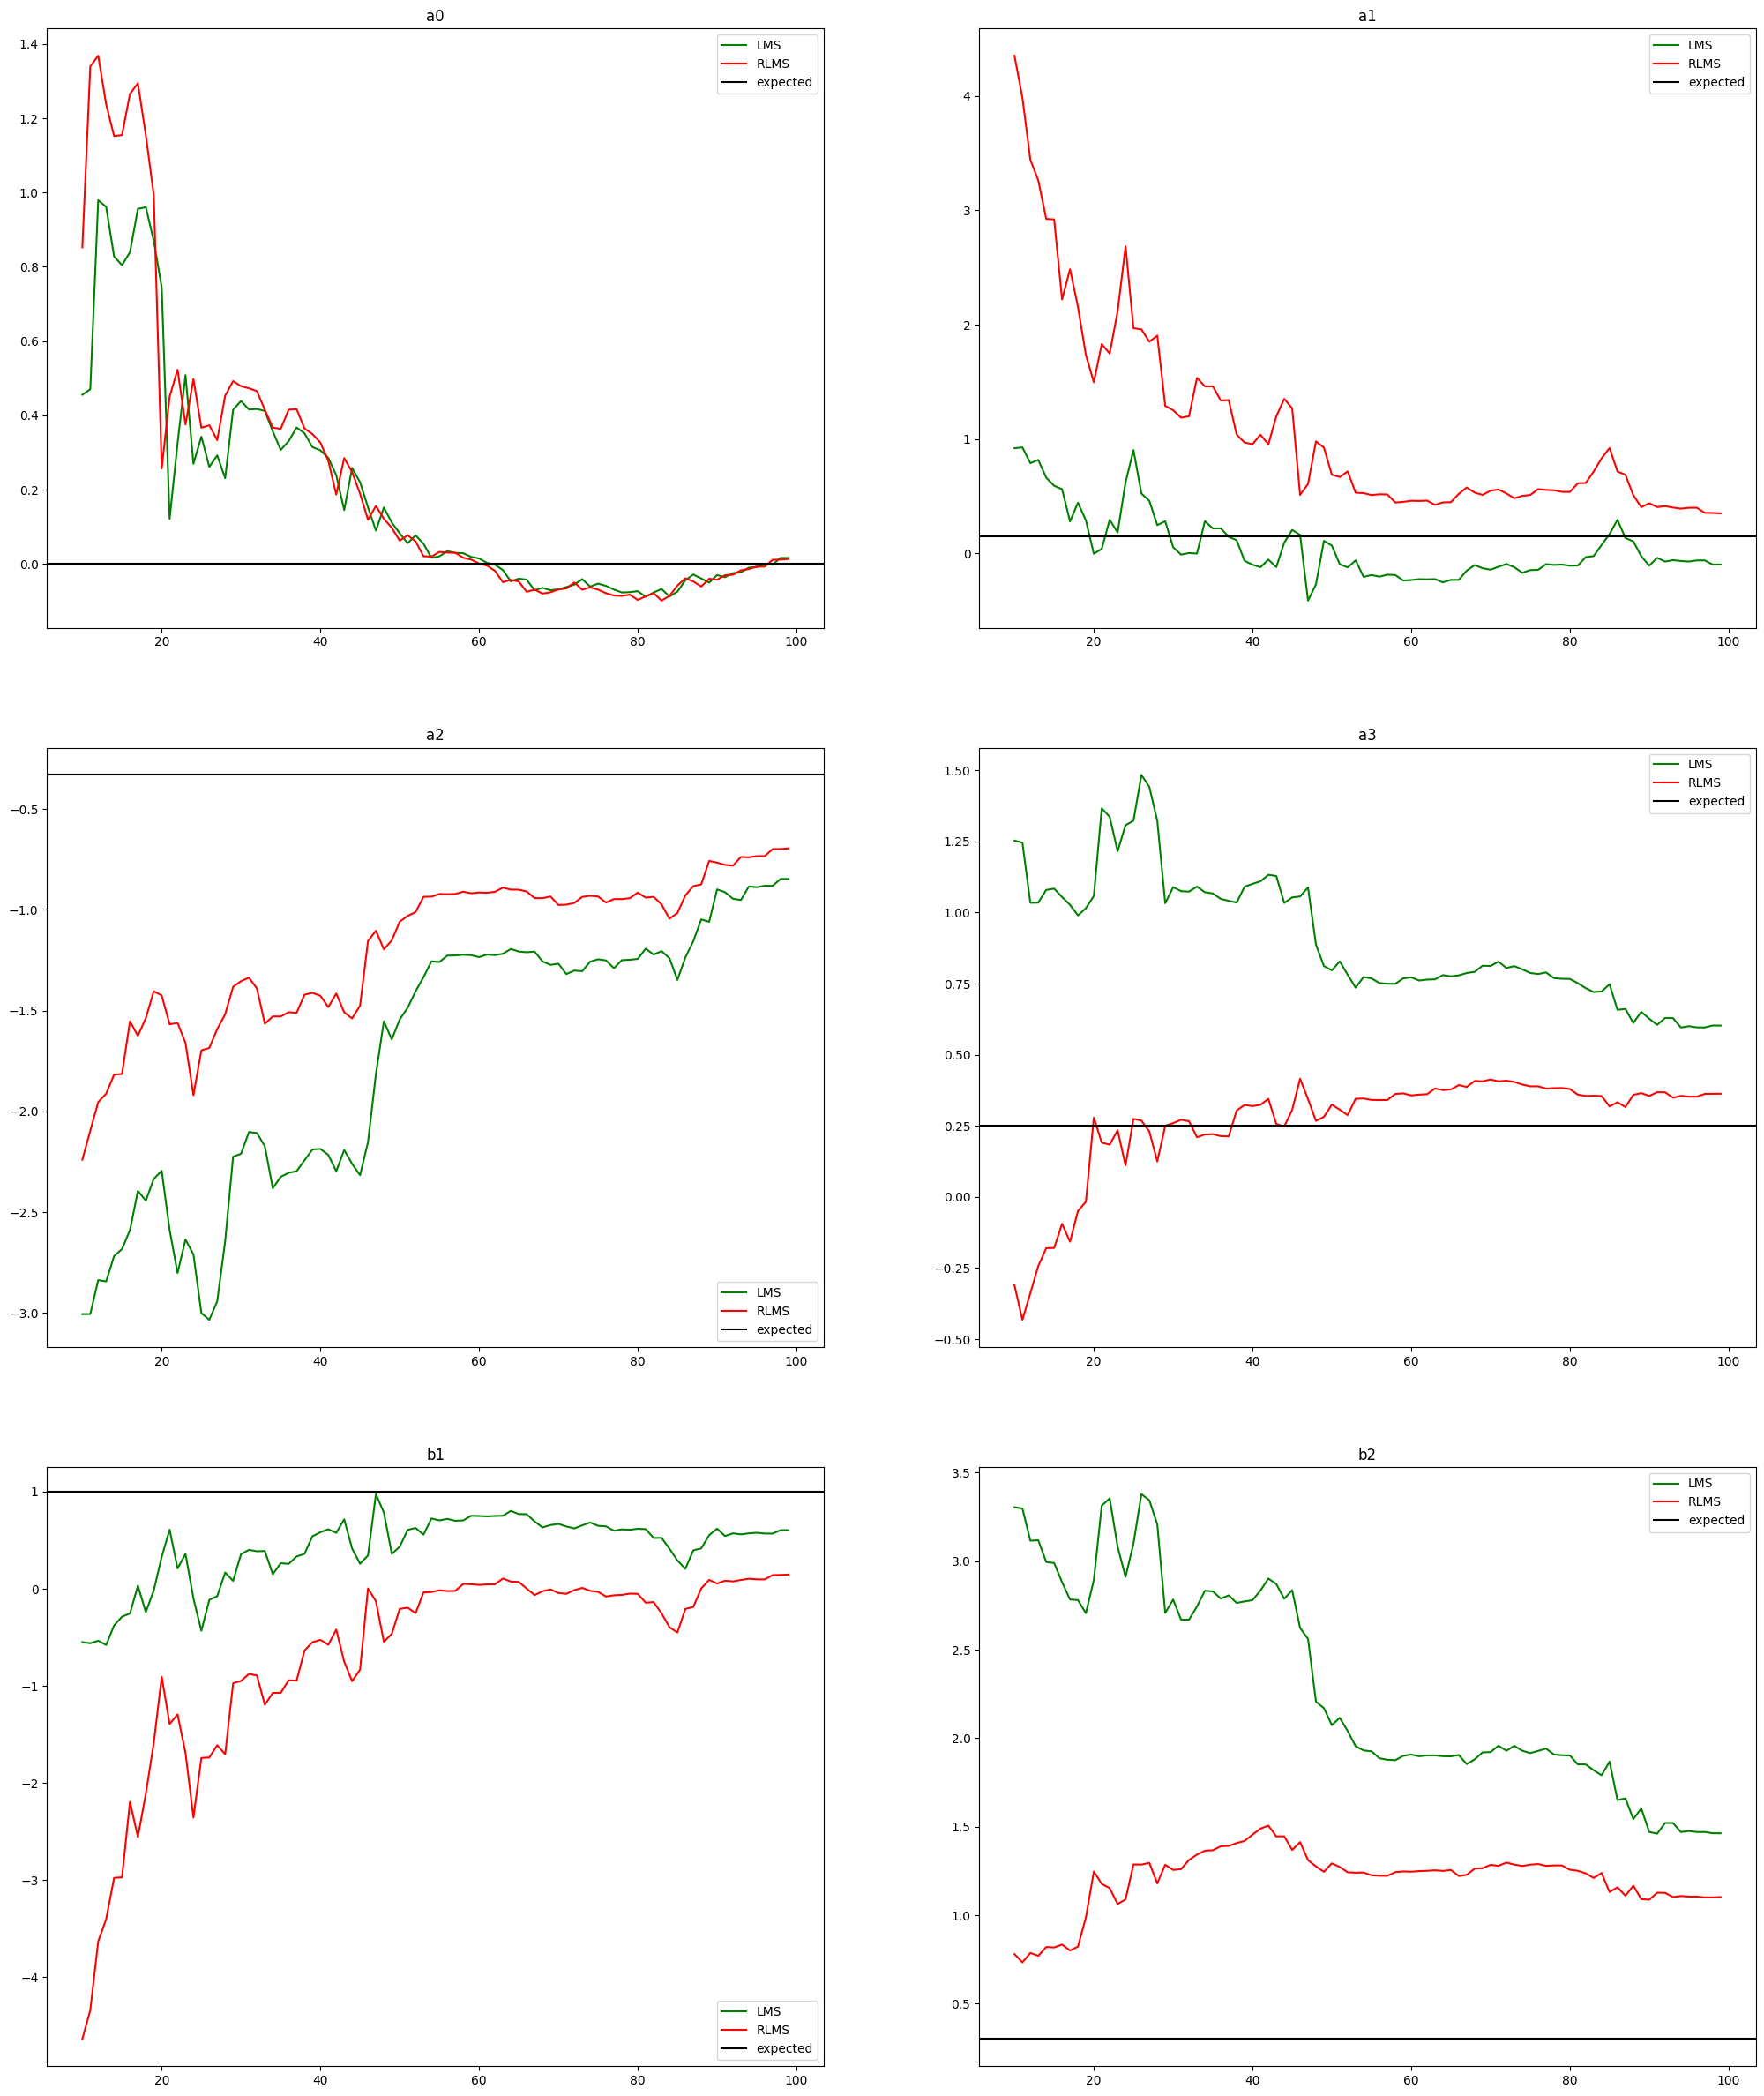

In [12]:
plot_dataframe(params['LMS'].iloc[10:], params['RLMS'].iloc[10:],'LMS', 'RLMS', np.hstack([a, b]))

### 4. Основні статистичні критерії

In [13]:
#коефіцієнт детермінаціі. чим ближче до 1, тим краще
def R2(y_true, y_pred):
    y_mean=y_true.mean()
    return((y_pred-y_mean)**2).sum()/((y_true-y_mean)**2).sum()


#RSS-residuals sum of squares(сума квадратів залишків)
def RSS(y_true, y_pred):
    return ((y_true-y_pred)**2).sum()


#теж саме що і IKA-інформаційний критерій Акаїке. Чим меньше тим краще
def AIC(y_true,y_pred, p,q):
    N=len(y_true)
    n=p+q+1
    return N*np.log( RSS(y_true,y_pred) )+2*n


def compose_all_metrics(y_true, y_pred, p, q):
    output = [RSS(y_true, y_pred), R2(y_true, y_pred), AIC(y_true,y_pred, p, q)]
    return np.array(output)

### 5. Порівняння результатів статистичних критеріїв для ***ARMA(n, k)*** iз ***LMS*** та ***RLMS***

In [14]:
columns=['RSS','R2','AIC']
report_df_lms = pd.DataFrame(
    np.array(np.array([[0]*len(columns)]*9)),
    columns=columns,
    dtype=np.float64,
    )
report_df_rlms = report_df_lms.copy()

indexes = []
for p in range(1, 4):
    for q in range(1, 4):
        indexes.append(f'ARMA({p},{q})')

        arma_lsm = ARMA_LSM(p, q)        
        y_pred, y_true = arma_lsm.fit_predict(v, y)
        metrics = compose_all_metrics(y_true, y_pred, p, q)
        report_df_lms.iloc[len(indexes)-1] = metrics

        arma_rlsm = ARMA_RLSM(p, q, 0, 1000)        
        arma_rlsm.fit(v, y)
        y_pred, y_true = arma_rlsm.predict_all(v, y)
        metrics = compose_all_metrics(y_true, y_pred, p, q)
        report_df_rlms.iloc[len(indexes)-1] = metrics


report_df_lms['method'] = 'LMS'
report_df_rlms['method'] = 'RLMS'

report_df_lms.index = indexes
report_df_rlms.index = indexes


In [15]:
report_df = pd.concat([report_df_lms, report_df_rlms])
report_df = report_df[['method', 'RSS', 'R2', 'AIC']]
# da = report_df.groupby('method').describe()

report_df

,method,RSS,R2,AIC
"ARMA(1,1)",LMS,108.875594,0.342088,470.330383
"ARMA(1,2)",LMS,99.900392,0.395952,459.209014
"ARMA(1,3)",LMS,97.543963,0.407275,454.289408
"ARMA(2,1)",LMS,105.388762,0.362767,464.450289
"ARMA(2,2)",LMS,99.590748,0.397824,460.904789
"ARMA(2,3)",LMS,97.533185,0.407340,456.278690
"ARMA(3,1)",LMS,104.455424,0.365277,460.929761
"ARMA(3,2)",LMS,93.522462,0.431711,452.205559
"ARMA(3,3)",LMS,93.433739,0.432250,454.113493
"ARMA(1,1)",RLMS,21987.515720,0.342080,995.824780


#### Побудуємо графіки

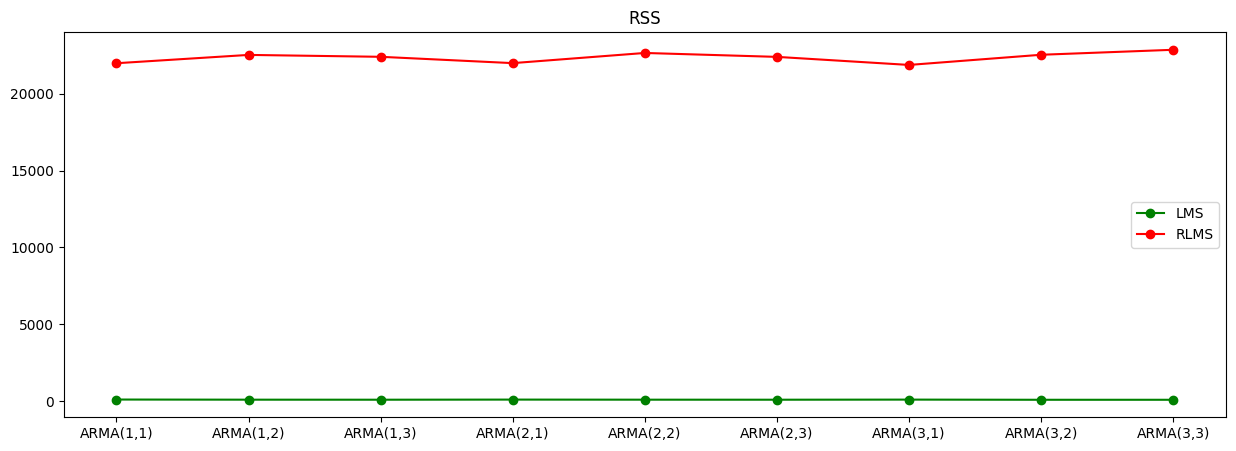

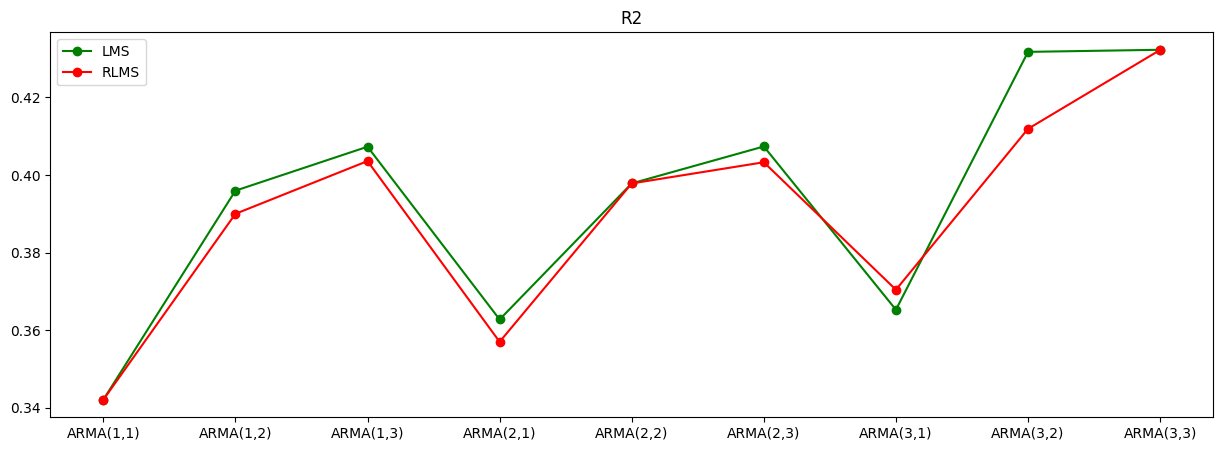

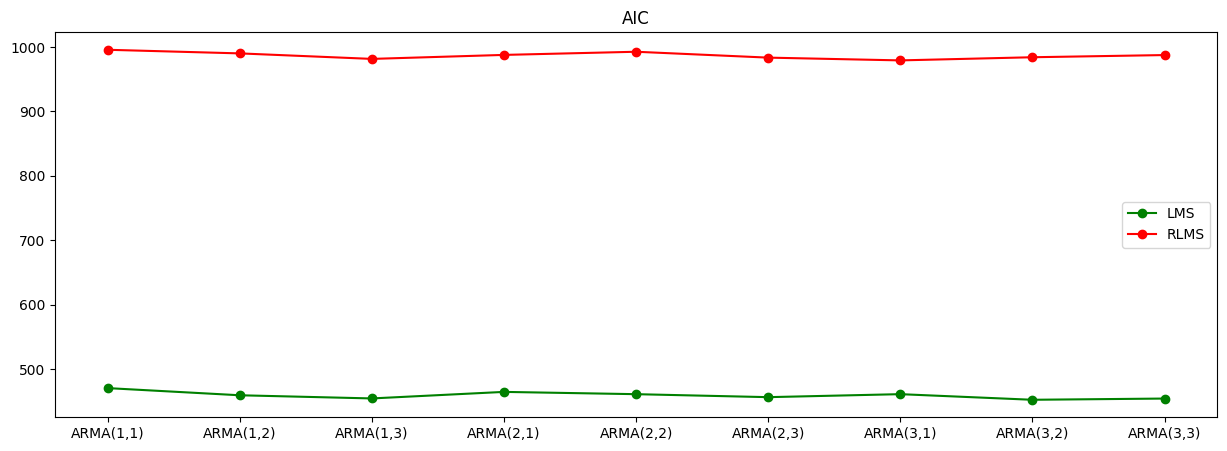

In [16]:
plt.figure(figsize=(15,5))
plt.title('RSS')
plt.plot(report_df.loc[report_df['method'] == 'LMS', 'RSS'], marker='o', color='green', label='LMS')
plt.plot(report_df.loc[report_df['method'] == 'RLMS', 'RSS'], marker='o', color='red', label='RLMS')
plt.legend()

plt.figure(figsize=(15,5))
plt.title('R2')
plt.plot(report_df.loc[report_df['method'] == 'LMS', 'R2'], marker='o', color='green', label='LMS')
plt.plot(report_df.loc[report_df['method'] == 'RLMS', 'R2'], marker='o', color='red', label='RLMS')
plt.legend()

plt.figure(figsize=(15,5))
plt.title('AIC')
plt.plot(report_df.loc[report_df['method'] == 'LMS', 'AIC'], marker='o', color='green', label='LMS')
plt.plot(report_df.loc[report_df['method'] == 'RLMS', 'AIC'], marker='o', color='red', label='RLMS')
plt.legend()

## **Висновки**
##### Ми навчились оцінювати коефіцієнти різницевого рівняння моделі авторегресії ковзного середнього за допомогою методу найменших квадратів та рекурсивного методу найменших квадратів. Розрахувавши основні статистичні критерії ми визначили найкращий метод оцінеювання параметрів РР — МНК для АРКС(3,2) і обрали "найкращу" модель для конкретного процесу.